# Application of deDANSy to describe the coordinated changes in gene expression and how distinct language subnetworks are.

Here, we showcase the final results after running deDANSy on several publicly available RNA-sequencing datasets. For each dataset, we provide the command line input used to generate the results on the high performance computing systems at UVA. These can also be run on a local machine given enough memory and time, but for certain datasets (e.g. the adipocyte culturing) will take multiple hours.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybiomart import Dataset
import generateCompleteProteome
import networkx as nx
import ngramNets

In [2]:
# Creating some default parameters for the matplotlib plots.
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3,3
plt.rcParams['axes.axisbelow'] = True

In [ ]:
complete_ref,_ = generateCompleteProteome.import_proteome_files()

# pybiomart database for gene name conversions
dataset = Dataset(host = 'http://useast.ensembl.org', name='hsapiens_gene_ensembl',)
gene_ID_conv = dataset.query(attributes=['ensembl_gene_id','external_gene_name','external_synonym','uniprotswissprot'])

In [4]:
# Defining helper functions to gather the results and plot them.
def get_plotting_data(res,metric):
    '''
    Gets the data that will be plotted in the bubble plot. Acceptable metrics are NS or IQR only.

    Parameters:
    -----------
        res: pandas DataFrame
            The imported data from running the enrichment analysis using the enrichment script.
        metric: str
            Which metric to retrieve.

    Returns:
    --------
        plot_data: pandas DataFrame
            The data that will be used for the plot
    '''
    if metric in['NS', 'IQR']:
        cat_map = {True:0, False:1}
    else:
        raise ValueError('Improper metric requested.')

    # Putting the data into the proper format
    plot_data = res[res['Metric'] == metric].drop("Metric", axis = 1)
    plot_data = plot_data.pivot(index = 'Comparison',columns = ['variable'])
    plot_data = plot_data['value'].reset_index()
    plot_data.columns.name = None

    # Adding in a few new variables related to the plot
    plot_data['FPR_Binary'] = plot_data[metric+'_FPR'] <= 0.05
    plot_data['Sign'] = plot_data[metric+' Cohen'] > 0
    plot_data['Score'] = np.abs(plot_data[metric+' Cohen'])
    plot_data['Category'] = plot_data['Sign'].map(cat_map)
    
    # Adding in some dummy variables to force some consistent sizes
    if metric == 'NS':
        for i in range(6):
            plot_data.loc[i+len(plot_data)] = None
            plot_data.loc[i+len(plot_data), 'Score'] = i
    else:
        # The IQR scores tend to be between 0-2 so getting the closest integer and then taking 5 steps to force the size
        max_vals = np.ceil(plot_data['Score'].max()) 
        for i,v in enumerate(np.linspace(0,max_vals,5)):
            plot_data.loc[i+len(plot_data)] = None
            plot_data.loc[i+len(plot_data), 'Score'] = v

    return plot_data


def plot_functional_scores(res, show_FPR_handle=True, aspect = 0.9):
     
    # Setting up the data and base plot
    data_plot = get_plotting_data(res, 'NS')
    _, axs = plt.subplots(1,2,figsize = (3,1.5))
    plt.subplot(1,2,1)
    sns.scatterplot(data_plot, y = 'Comparison', size='Score', x = 'Category',
    hue='FPR_Binary',sizes = (1,50), size_norm = (0,5),
                    palette=['mediumorchid', 'silver'],hue_order=[True, False],
                    linewidth = 0.5,edgecolor='k')
    plt.gca().set_aspect(aspect)

    # Adding in labels
    plt.title('Separation Relative\nto Random Genes',fontdict={'size':5})
    plt.xlabel(None)

    # Ensuring both ticks are present even if one of the categories is missing.
    plt.xticks([0,1],['More', 'Less'], rotation=45, ha='right')
    plt.xlim(-0.5,1.5)
    
    # Cleaning up the legend slightly
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles, new_labels = clean_up_legend(handles, labels, show_FPR_handle)
    l = plt.legend(new_handles,new_labels,bbox_to_anchor=(1,1), edgecolor='k', handletextpad=0.1)
    l.get_frame().set_linewidth(0.5)
   
    # When there are several comparisons it is a little easier to digest when there are grid lines
    if len(set(data_plot['Comparison'].tolist())) >= 3:
        plt.grid(visible=True,axis='y', linewidth =0.25, linestyle= ':')

    # Now the IQR version
    data_plot = get_plotting_data(res, 'IQR')
    plt.subplot(1,2,2)
    sns.scatterplot(data_plot, y = 'Comparison', size='Score', x = 'Category',
    hue='FPR_Binary',sizes = (1,50),
                    palette=['seagreen', 'silver'],hue_order=[True, False],
                    linewidth = 0.5,edgecolor='k', legend='brief')
    
    plt.xticks([0,1],['Stably Distinct', 'Unstable/Overlap'], rotation=45, ha='right')
    plt.xlabel(None)
    plt.title('Enriched \nn-gram neighborhoods',fontdict={'size':5})
    plt.xlim([-0.5,1.5])
    plt.gca().set_aspect(aspect)
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles, new_labels = clean_up_legend(handles, labels, show_FPR_handle)
    l = plt.legend(new_handles,new_labels,bbox_to_anchor=(1,1), edgecolor='k', handletextpad=0.1)
    l.get_frame().set_linewidth(0.5)
    
    plt.ylabel(None)
    plt.tick_params('y',labelleft=None)
    
    if len(set(data_plot['Comparison'].tolist())) >=3:
        plt.grid(visible=True,axis='y', linewidth =0.25, linestyle= ':')
        
    return axs

def clean_up_legend(handles, labels, show_FPR = True):
    
    if show_FPR:
            handles_2_rm = [5,7,9]
    else:
        handles_2_rm = [0,1,2,5,7,9] #Will not always need the FPR legend details so will remove them as well
    
    new_h = [h for i,h in enumerate(handles) if i not in handles_2_rm]
    new_l = [h for i,h in enumerate(labels) if i not in handles_2_rm]
    
    if show_FPR:
        new_l[0] = 'FPR$\leq$0.05'
        new_h.insert(3,new_h[3])
        new_l.insert(3,'')
    
    return new_h, new_l

def format_results(dataset_results):
    
    variables_2_keep = ['NS Cohen', 'IQR Cohen', 'NS p_log', 'IQR p_log', 'NS_FPR', 'IQR_FPR']
    res = dataset_results[dataset_results['variable'].isin(variables_2_keep)].copy()
    res['Metric'] = res['variable'].str.split(' ').str[0]
    res['Metric'] = res['Metric'].str.split('_').str[0]

    return res
    

## Adipocyte Culturing Methods

This dataset comes from this [study](https://doi.org/10.1016/j.celrep.2019.03.026), which focused on improving mature adipocyte culturing methods due to difficulty in maintaining their identity through existing methods.

This dataset was spread over three runs due to the number of DEGs associated between conditions. The command line prompts used for this were as follows:

    python ngram_min_test.py DEG_data/Adipocyte_Culture_Methods_DEG_Results.csv deDANSy_Results/adipocyte_large_set Float_v_Packed Packed_v_Diff -mp 8 -sN 100 -fN 50 --seed 882 -fc 3 -a 0.0001

    python ngram_min_test.py DEG_data/Adipocyte_Culture_Methods_DEG_Results.csv deDANSy_Results/adipocyte_medium_set Diff_v_Undiff Float_v_Diff -mp 8 -sN 100 -fN 50 --seed 882 -fc 3 -a 0.0001

    python ngram_min_test.py DEG_data/Adipocyte_Culture_Methods_DEG_Results.csv deDANSy_Results/adipocyte_small_set Float_v_TW Float_v_Explant Float_v_Fresh Explant_v_Whole -mp 8 -sN 100 -fN 50 --seed 882 -fc 3 -a 0.0001

The process to find the DEG cutoffs are provided below as well.

### Determining DEG cutoffs:

DEGs were defined in the end as any gene with a log2 fold change > 3 and p-adjusted value <0.0001. This give us the most conditions with 100-1500 genes as DEGs. Below we show only the change in DEG counts for both the fold-change of 1 and 3 to save space.

As part of the process define the DANSy object, which contains all the data, to show built-in functionality to define DEGs without prior processing.

In [5]:
adipocyte_df = pd.read_csv('DEG_data/Adipocyte_Culture_Methods_DEG_Results.csv')
adipo_nets = ngramNets.DEdansy(adipocyte_df, gene_ID_conv,uniprot_ref=complete_ref, data_ids='gene_id')
adipo_conds = ['Float_v_Diff','Float_v_TW','Float_v_Explant','Float_v_Fresh','Float_v_Packed','Packed_v_Diff','Explant_v_Whole','Diff_v_Undiff']

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


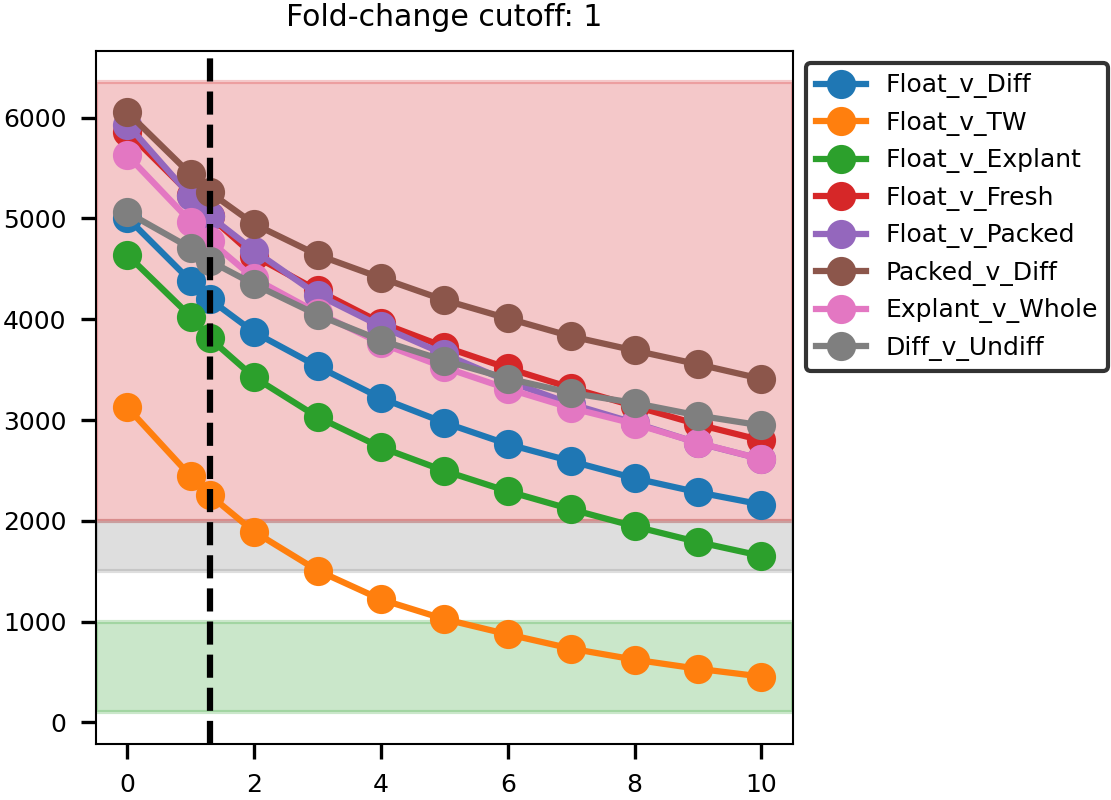

In [6]:
degnn = adipo_nets
conds = adipo_conds
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)

full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=1)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))
plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()

# Indicator of decent zones to be in for analysis
plt.fill_between([-0.5,10.5], y1=100, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:gray')
plt.fill_between([-0.5,10.5], y1=2000, y2 = np.max([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:red')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds, bbox_to_anchor=(1,1))
plt.title('Fold-change cutoff: 1')
plt.margins(x = 0)

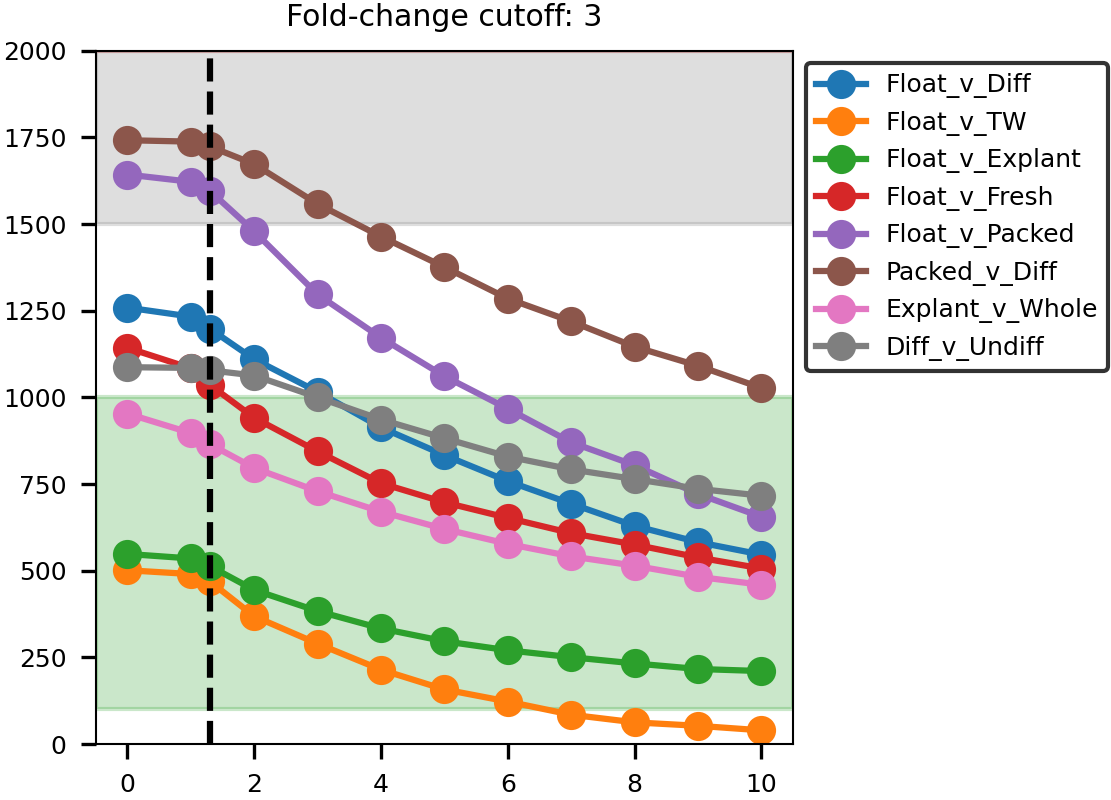

In [7]:
degnn = adipo_nets
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = adipo_conds
full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=3)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs


x = np.tile(-np.log10(p_vals), (len(conds),1))
plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.ylim(0,2000)
plt.fill_between([-0.5,10.5], y1=100, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:gray')
plt.fill_between([-0.5,10.5], y1=2000, y2 = np.max([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:red')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds, bbox_to_anchor=(1,1))
plt.title('Fold-change cutoff: 3')
plt.margins(x = 0)

In [8]:
# Printing how many DEGs for each condition were used for the analysis.
degnn = adipo_nets
for cond in adipo_conds:
    degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.0001,fc_thres=3,batch_mode=True)
    degNums = len(degnn.up_DEGs + degnn.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

Comparison Float_v_Diff has 913 DEGs used for analysis.
Comparison Float_v_TW has 214 DEGs used for analysis.
Comparison Float_v_Explant has 333 DEGs used for analysis.
Comparison Float_v_Fresh has 752 DEGs used for analysis.
Comparison Float_v_Packed has 1172 DEGs used for analysis.
Comparison Packed_v_Diff has 1464 DEGs used for analysis.
Comparison Explant_v_Whole has 670 DEGs used for analysis.
Comparison Diff_v_Undiff has 936 DEGs used for analysis.


### deDANSy results

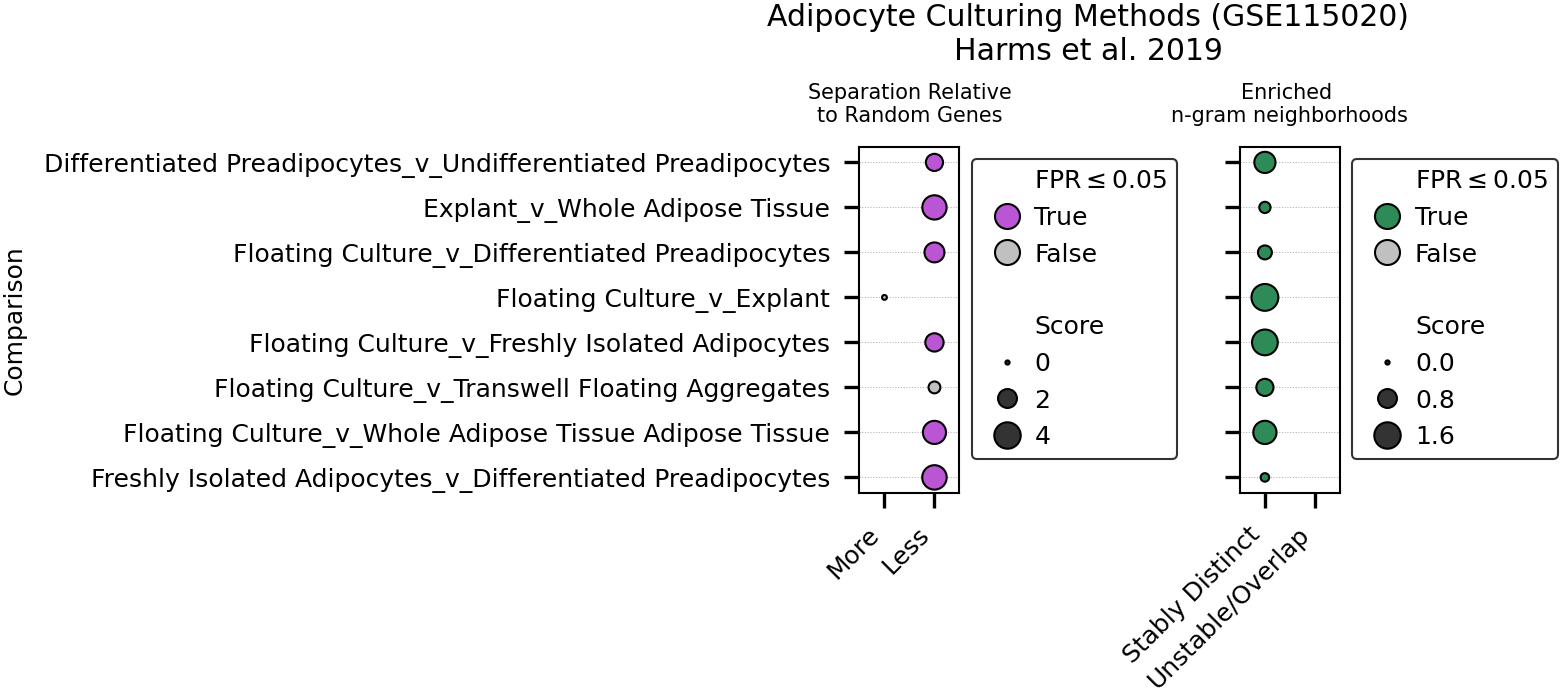

In [ ]:
# Importing the data to be plotted
files = ['adipocyte_large_set', 'adipocyte_medium_set', 'adipocyte_small_set']
dataset = pd.DataFrame()
for file in files:
    filename = 'deDANSy_Results/' + file+ '_Results_Summary_Stats.csv'
    temp = pd.read_csv(filename)
    dataset = pd.concat([dataset, temp])
res = format_results(dataset)

# Renaming some of the comparisons to their long form
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('Diff', 'Differentiated Preadipocytes') if 'Diff' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('Undiff', 'Undifferentiated Preadipocytes') if 'Undiff' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('Float', 'Floating Culture') if 'Float' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('TW', 'Transwell Floating Aggregates') if 'TW' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('Fresh', 'Whole Adipose Tissue') if 'Fresh' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('Whole', 'Whole Adipose Tissue') if 'Whole' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('Packed', 'Freshly Isolated Adipocytes') if 'Packed' in x else x)

# Plotting
ax = plot_functional_scores(res)
plt.suptitle('Adipocyte Culturing Methods (GSE115020)\nHarms et al. 2019', y = 1.2)
plt.show()
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/Adipocyte Whole Network Results.svg')

## Induced Brain Microvascular Endothelial Cells Co-culturing changes

Here, we focus on a dataset which cultured induced brain microvascular endothelial cells (iBMECs) differentiated from iPSCs when co-cultured with different brain microenvironment cells within a microfluidic tissue culture chip. These results come from [this study](https://doi.org/10.1016/j.stem.2019.05.011) focusing on better modeling the brain blood barrier. These results come from the samples used to study the co-culture effects.

The command line prompt for these are as follows. For one condition needed to let it be a little more permissive to reach lower limits of deDANSy:

    python ngram_min_test.py DEG_data/iBMEC_Coculture_DEG_Results.csv deDANSy_Results/bmec_coculture_norm AP_v_iNeural iNeural_v_no -mp 8 -sN 100 -fN 50 --seed 882 -fc 1 -a 0.05

    python ngram_min_test.py DEG_data/iBMEC_Coculture_DEG_Results.csv deDANSy_Results/bmec_coculture_permissive AP_v_no -mp 8 -sN 100 -fN 50 --seed 882 -fc 0.585 -a 0.05
    
    

### Defining DEGs

In [ ]:
bmec_coculture_data = pd.read_csv('DEG_data/iBMEC_Coculture_DEG_Results.csv')
bmec_coculture_nets = ngramNets.DEdansy(bmec_coculture_data, gene_ID_conv,uniprot_ref=complete_ref, data_ids='ensembl_gene_id')
bmec_coculture_conds = ['AP_v_no','iNeural_v_no','AP_v_iNeural']

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


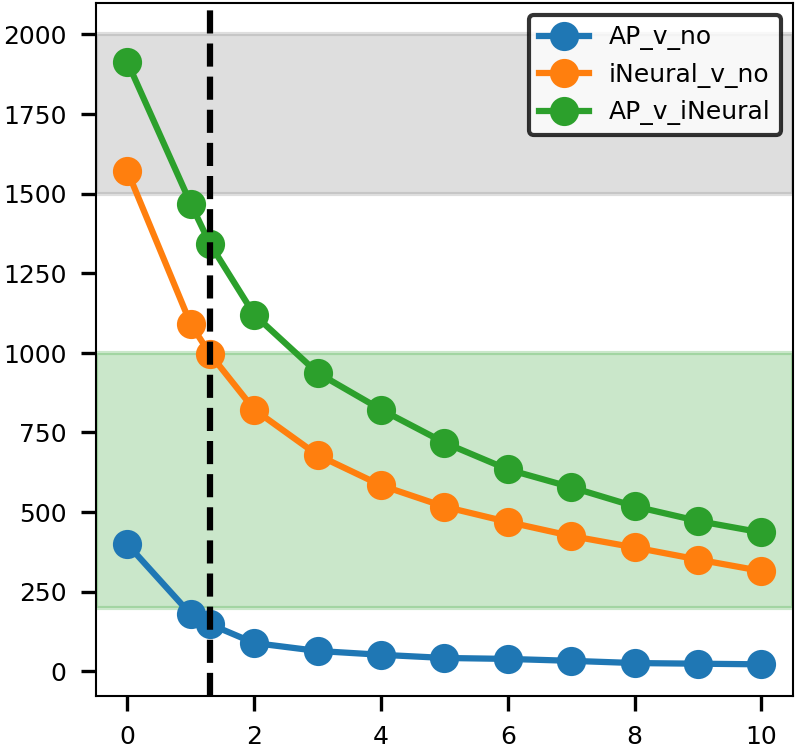

In [11]:
degnn = bmec_coculture_nets
conds = bmec_coculture_conds
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)

full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=0.585)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:gray')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)

From above the AP_v_no comparison would have too few DEGs, so we chose the most permissive cutoff that still resembles a significant difference in expression.

In [12]:
degnn = bmec_coculture_nets
for cond in ['AP_v_iNeural', 'iNeural_v_no']:
    degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05,fc_thres=1,batch_mode=True)
    degNums = len(degnn.up_DEGs + degnn.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

for cond in ['AP_v_no']:
    degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05,fc_thres=0.585,batch_mode=True)
    degNums = len(degnn.up_DEGs + degnn.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

Comparison AP_v_iNeural has 459 DEGs used for analysis.
Comparison iNeural_v_no has 375 DEGs used for analysis.
Comparison AP_v_no has 148 DEGs used for analysis.


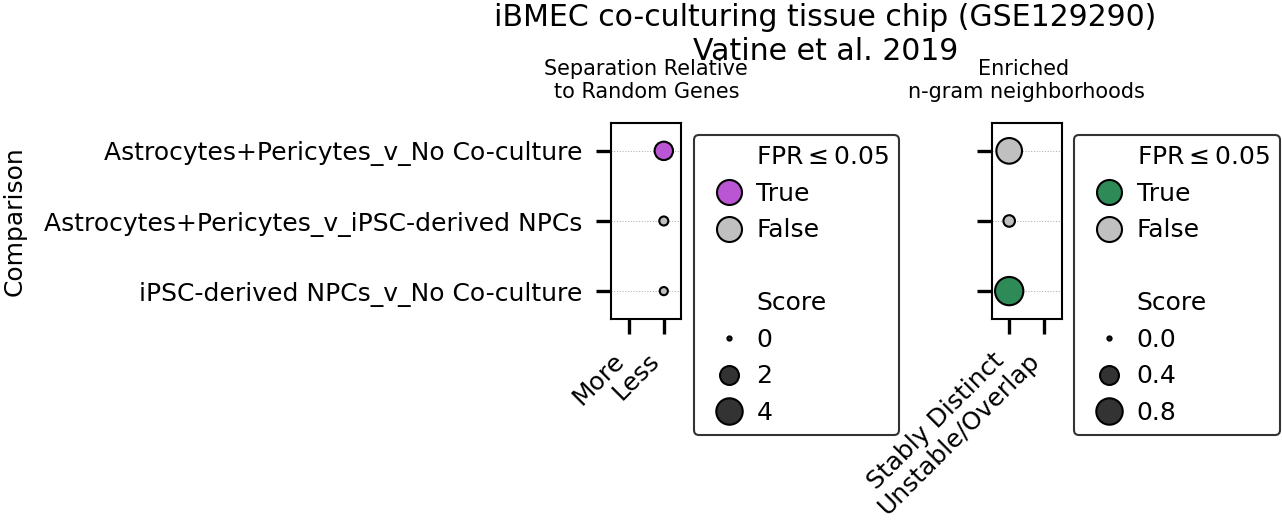

In [ ]:
# Importing the data to be plotted
files = ['bmec_coculture_norm', 'bmec_coculture_permissive']
dataset = pd.DataFrame()
for file in files:
    filename = 'deDANSy_Results/' + file+ '_Results_Summary_Stats.csv'
    temp = pd.read_csv(filename)
    dataset = pd.concat([dataset, temp])
res = format_results(dataset)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('AP', 'Astrocytes+Pericytes') if 'AP' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('iNeural', 'iPSC-derived NPCs') if 'iNeural' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('no', 'No Co-culture') if 'no' in x else x)
axs = plot_functional_scores(res, aspect=2)
axs[0].margins(y =0.2)
axs[1].margins(y =0.2)
plt.gcf().set_size_inches(h =0.85, w = 3)
plt.suptitle('iBMEC co-culturing tissue chip (GSE129290)\nVatine et al. 2019', y = 1.35)
plt.show()
# plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/iBMEC Coculturing Results.svg')

## iBMEC response to flow in tissue chips

From the same study above, these results focus on iBMECs cultured with different fluid flow rates through the microfluidic channels of the tissue chip.

Command line prompts used. Note like the coculture results there were several comparisons that required a more permissive cutoff to define enough DEGs for deDANSy.:

    python ngram_min_test.py DEG_data/iBMEC_Flow_DEG_Results.csv deDANSy_Results/bmec_flow_norm 2-4dyn_v_0dyn 0-5dyn_v_0dyn -mp 8 -sN 100 -fN 50 --seed 882 -fc 1 -a 0.05

    python ngram_min_test.py DEG_data/iBMEC_Flow_DEG_Results.csv deDANSy_Results/bmec_flow_low 0-5dyn_v_0-01dyn 2-4dyn_v_0-01dyn 0-01dyn_v_0dyn -mp 8 -sN 100 -fN 50 --seed 882 -fc 1 -a 0.05

### Defining DEG cutoffs

In [ ]:
bmec_flow_data = pd.read_csv('DEG_data/iBMEC_Flow_DEG_Results.csv')
bmec_flow_nets = ngramNets.DEdansy(bmec_flow_data, gene_ID_conv,uniprot_ref=complete_ref, data_ids='ensembl_gene_id')
bmec_flow_conds = ['2-4dyn_v_0dyn','0-5dyn_v_0dyn','0-01dyn_v_0dyn','0-5dyn_v_0-01dyn','2-4dyn_v_0-01dyn','2-4dyn_v_0-5dyn']

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


Below showing both fold change cutoffs of 1 and 0.585

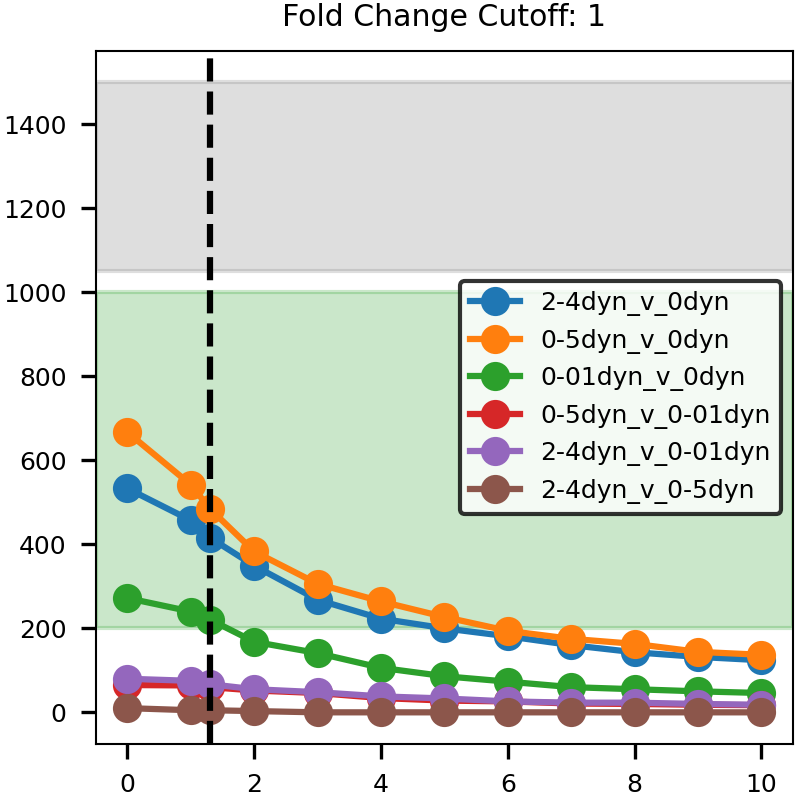

In [15]:
degnn = bmec_flow_nets
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = bmec_flow_conds
full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=1)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:gray')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)
plt.title('Fold Change Cutoff: 1')
plt.show()

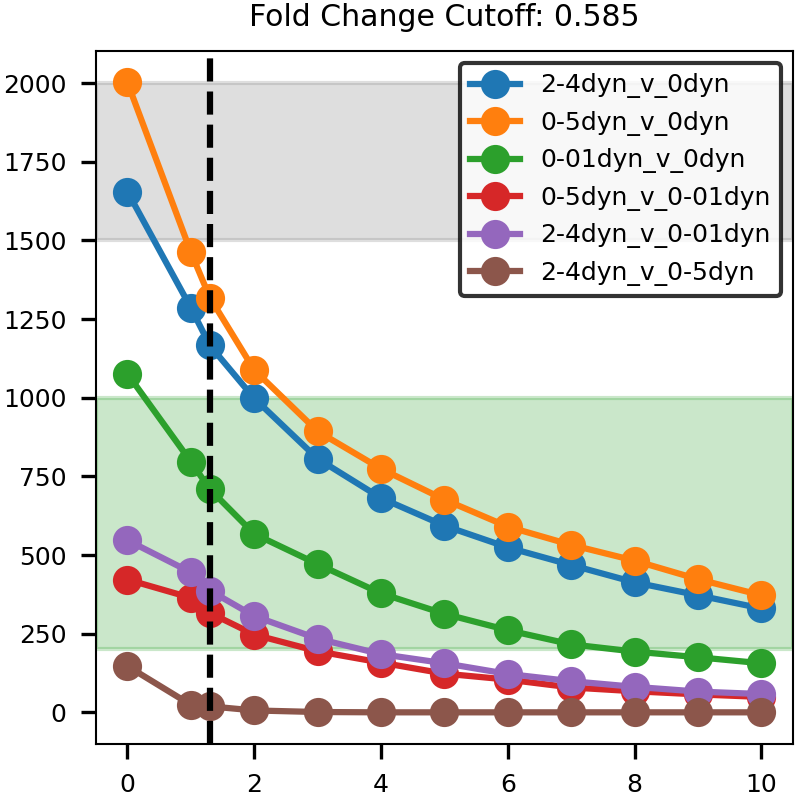

In [16]:
degnn = bmec_flow_nets
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = bmec_flow_conds
full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=0.585)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:gray')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)
plt.title('Fold Change Cutoff: 0.585')
plt.show()

In [17]:
degnn = bmec_flow_nets
for cond in ['2-4dyn_v_0dyn', '0-5dyn_v_0dyn']:
    degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05,fc_thres=1,batch_mode=True)
    degNums = len(degnn.up_DEGs + degnn.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

for cond in ['0-5dyn_v_0-01dyn', '2-4dyn_v_0-01dyn', '0-01dyn_v_0dyn']:
    degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05,fc_thres=0.585,batch_mode=True)
    degNums = len(degnn.up_DEGs + degnn.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

Comparison 2-4dyn_v_0dyn has 416 DEGs used for analysis.
Comparison 0-5dyn_v_0dyn has 485 DEGs used for analysis.
Comparison 0-5dyn_v_0-01dyn has 316 DEGs used for analysis.
Comparison 2-4dyn_v_0-01dyn has 387 DEGs used for analysis.
Comparison 0-01dyn_v_0dyn has 709 DEGs used for analysis.


### deDANSy Results

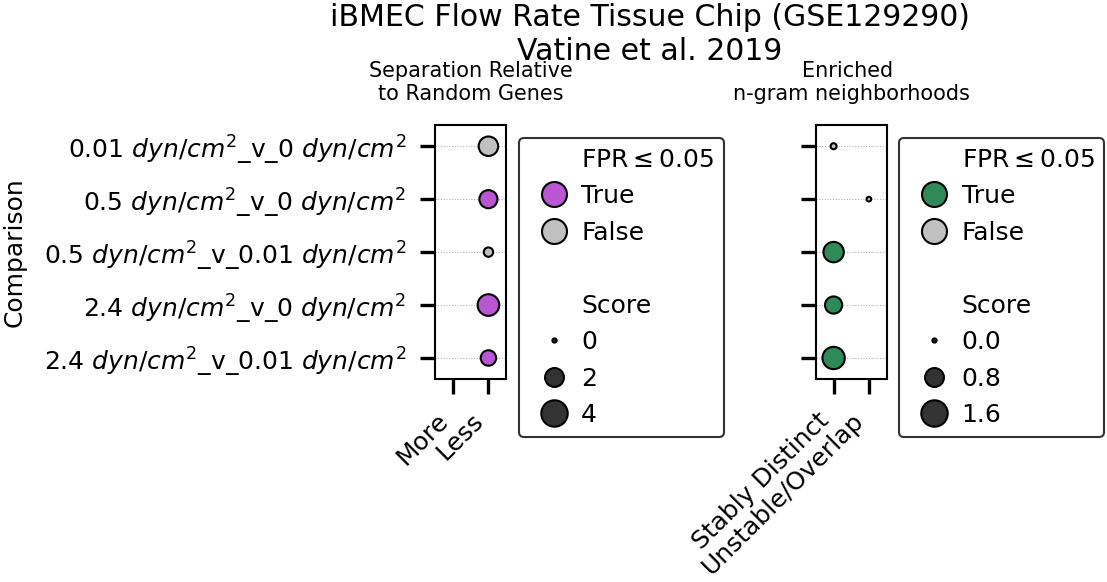

In [ ]:
# Importing the data to be plotted
files = ['bmec_flow_low', 'bmec_flow_norm']
dataset = pd.DataFrame()
for file in files:
    filename = 'deDANSy_Results/' + file+ '_Results_Summary_Stats.csv'
    temp = pd.read_csv(filename)
    dataset = pd.concat([dataset, temp])
res = format_results(dataset)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('dyn', ' $dyn/cm^2$') if 'dyn' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('-', '.') if '-' in x else x)
axs = plot_functional_scores(res, aspect=1.5)
axs[0].margins(y =0.1)
axs[1].margins(y =0.1)
plt.gcf().set_size_inches(h =1.1, w = 3)
plt.suptitle('iBMEC Flow Rate Tissue Chip (GSE129290)\nVatine et al. 2019', y = 1.25)
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/iBMEC Flow Results.svg')
plt.show()

# SOX10 deficiency in melanoma cells

This is from the study that focused on understanding how SOX10-deficient melanoma cells, which exhibit a more dormant and invasive phenotype, can be targeted to improve therapeutic response. The results come from this [study](https://doi.org/10.1038/s41467-022-28801-y) and the results below are the expanded results from what is provided in the specific deDANSy results notebook.

Like the adipocyte dataset, this was spread over 4 command line prompts for more efficient computational resources (and also one set of conditions required slightly different cutoffs).

    python ngram_min_test.py DEG_data/SOX10_invasion_DEG_Results.csv deDANSy_Results/sox10_large_set CRT34_v_A375 CRT35_v_A375 -mp 8 -sN 100 -fN 50 --seed 882 -fc 2 -a 0.001

    python ngram_min_test.py DEG_data/SOX10_invasion_DEG_Results.csv deDANSy_Results/sox10_medium_set CRT34_v_4-11 CRT34_v_2-18 CRT35_v_4-11 CRT35_v_2-18 -mp 8 -sN 100 -fN 50 --seed 882 -fc 2 -a 0.001

    python ngram_min_test.py DEG_data/SOX10_invasion_DEG_Results.csv deDANSy_Results/sox10_small_set 4-11_v_A375 2-18_v_A375 4-11_v_2-18 -mp 8 -sN 100 -fN 50 --seed 882 -fc 2 -a 0.001

    python ngram_min_test.py DEG_data/SOX10_invasion_DEG_Results.csv deDANSy_Results/sox10_diff_set CRT35_v_CRT34 CRT34_v_CRT34drug CRT35_v_CRT35drug -mp 8 -sN 100 -fN 50 --seed 882 -fc 1 -a 0.01

### Defining DEGs

Here showing both fold change values to show how many DEGs could have been used. Since the CRT cells when compared to one another and in the presence of drug where experimentally the closest together these were grouped together for the more permissive cutoffs.

In [ ]:
sox10_dataset = pd.read_csv('DEG_data/SOX10_Invasion_DEG_Results.csv')
sox10_nets = ngramNets.DEdansy(sox10_dataset, gene_ID_conv,uniprot_ref=complete_ref, data_ids='ensembl_gene_id')
sox10_conds = ['4-11_v_A375','2-18_v_A375','4-11_v_2-18','CRT34_v_A375', 'CRT35_v_A375','CRT35_v_CRT34','CRT34_v_CRT34drug','CRT35_v_CRT35drug','CRT34_v_2-18', 'CRT34_v_4-11','CRT35_v_2-18', 'CRT35_v_4-11']

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


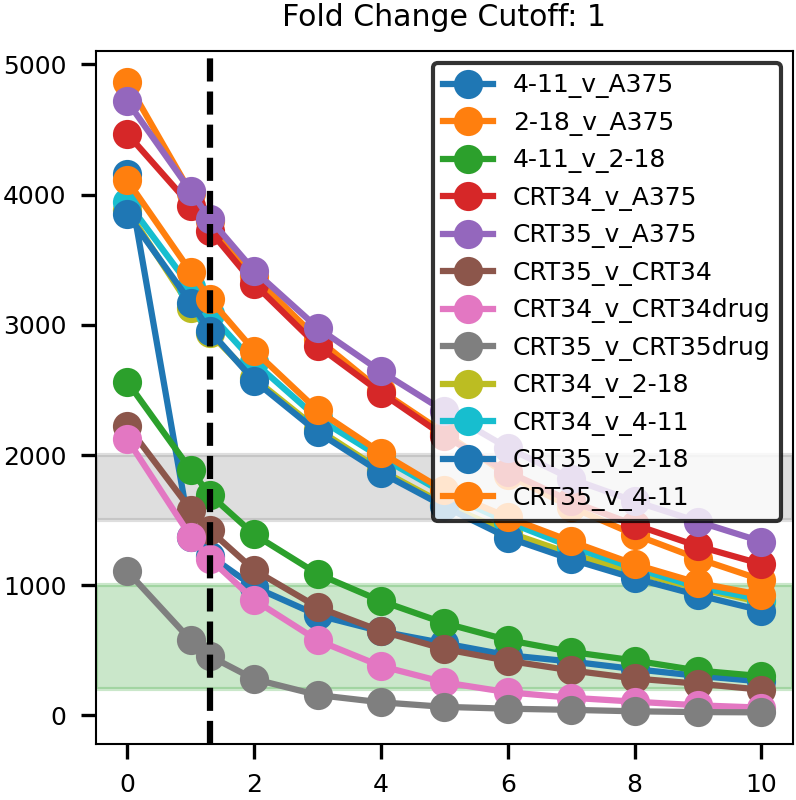

In [20]:
degnn = sox10_nets
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = sox10_conds
full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=1)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:gray')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)
plt.title('Fold Change Cutoff: 1')
plt.show()

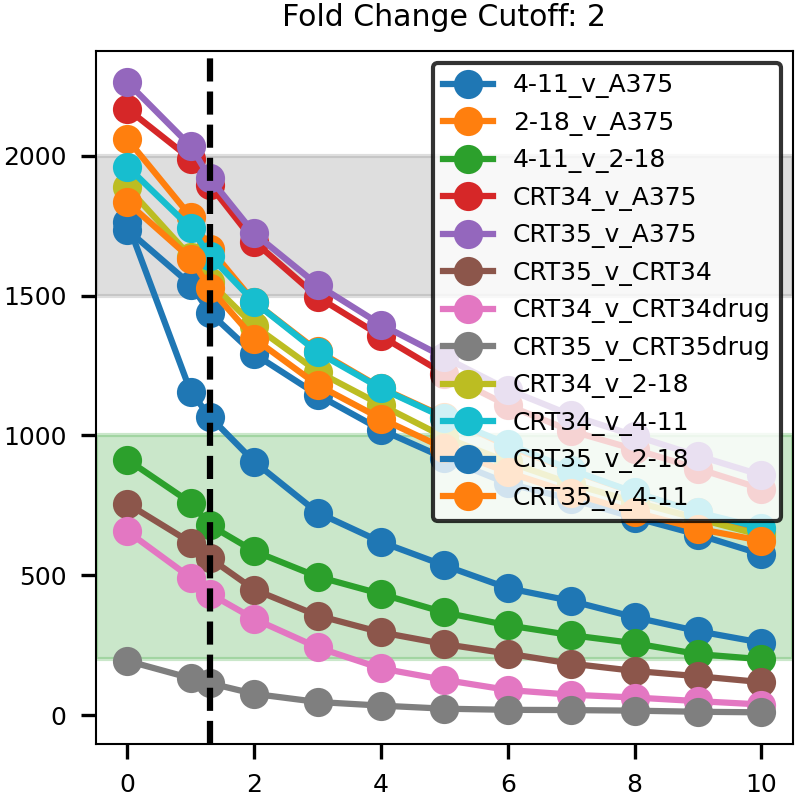

In [21]:
degnn = sox10_nets
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = sox10_conds
full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=2)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:gray')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)
plt.title('Fold Change Cutoff: 2')
plt.show()

In [22]:
degnn = sox10_nets
spec_conds = ['CRT35_v_CRT35drug','CRT34_v_CRT34drug', 'CRT35_v_CRT34']
for cond in sox10_conds:
    if cond not in spec_conds:
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.001,fc_thres=2,batch_mode=True)
        degNums = len(degnn.up_DEGs + degnn.down_DEGs)
        print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

for cond in spec_conds:
    degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.01,fc_thres=1,batch_mode=True)
    degNums = len(degnn.up_DEGs + degnn.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

Comparison 4-11_v_A375 has 724 DEGs used for analysis.
Comparison 2-18_v_A375 has 1302 DEGs used for analysis.
Comparison 4-11_v_2-18 has 495 DEGs used for analysis.
Comparison CRT34_v_A375 has 1495 DEGs used for analysis.
Comparison CRT35_v_A375 has 1538 DEGs used for analysis.
Comparison CRT34_v_2-18 has 1228 DEGs used for analysis.
Comparison CRT34_v_4-11 has 1297 DEGs used for analysis.
Comparison CRT35_v_2-18 has 1145 DEGs used for analysis.
Comparison CRT35_v_4-11 has 1180 DEGs used for analysis.
Comparison CRT35_v_CRT35drug has 278 DEGs used for analysis.
Comparison CRT34_v_CRT34drug has 886 DEGs used for analysis.
Comparison CRT35_v_CRT34 has 1116 DEGs used for analysis.


### deDANSy Results

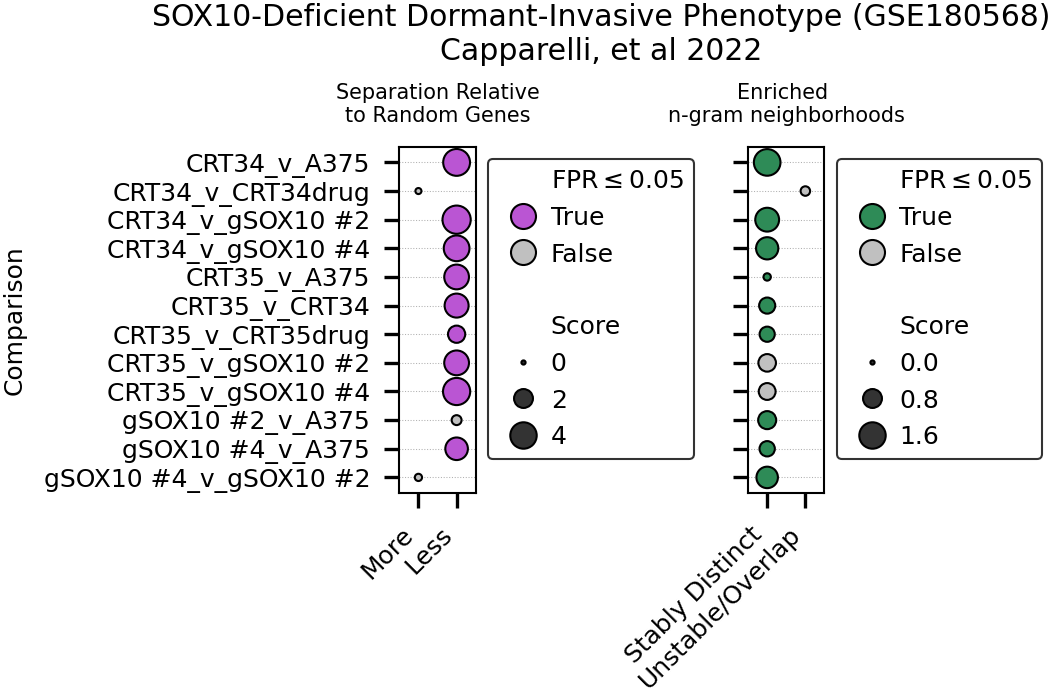

In [ ]:
# Importing the data to be plotted
files = ['sox10_diff_set','sox10_large_set', 'sox10_medium_set', 'sox10_small_set']
dataset = pd.DataFrame()
for file in files:
    filename = 'deDANSy_Results/' + file+ '_Results_Summary_Stats.csv'
    temp = pd.read_csv(filename)
    dataset = pd.concat([dataset, temp])
res = format_results(dataset)

# Replacing some of the labels to make them more clear
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('2-18', 'gSOX10 #2') if '2-18' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('4-11', 'gSOX10 #4') if '4-11' in x else x)


plot_functional_scores(res, aspect = 0.75)
plt.gcf().set_size_inches(h =1.5, w = 2.75)
plt.suptitle('SOX10-Deficient Dormant-Invasive Phenotype (GSE180568)\nCapparelli, et al 2022', y = 1.2)
plt.show()
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/SOX10_Analysis.svg')

## Breast Cancer Cell Tumor dormancy and Type III Collagen

This dataset comes from this [study](https://doi.org/10.1038/s43018-021-00291-9) (PMID: [35121989](https://pubmed.ncbi.nlm.nih.gov/35121989/)), which focused on studying how breast cancer cells establish a dormant niche that supports metastatic dissemination that is not clinically detectable.

The command line prompt for these are as follows:

    python ngram_min_test.py DEG_data/Dormancy_DDR_DEG_Results.csv deDANSy_Results/dormancy_large DHEP_v_THEP DHEPsC_v_THEP DHEPsD_v_THEP -mp 8 -sN 100 -fN 50 --seed 882 -fc 2 -a 0.05  

    python ngram_min_test.py DEG_data/Dormancy_DDR_DEG_Results.csv deDANSy_Results/dormancy_permissive DHEPsD_v_DHEPsC DHEPsC_v_DHEP -mp 8 -sN 100 -fN 50 --seed 882 -fc 0.585 -a 0.05

In [ ]:
dorm_data = pd.read_csv('DEG_data/Dormancy_DDR_DEG_Results.csv')
dorm_nets = ngramNets.DEdansy(dorm_data, gene_ID_conv,uniprot_ref=complete_ref, data_ids='ensembl_gene_id')
dorm_conds = ['DHEP_v_THEP','DHEPsC_v_THEP','DHEPsC_v_DHEP','DHEPsD_v_DHEPsC','DHEPsD_v_THEP',]


Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


### Defining DEGs

Text(0.5, 1.0, 'Fold Change Cutoff: 0.585')

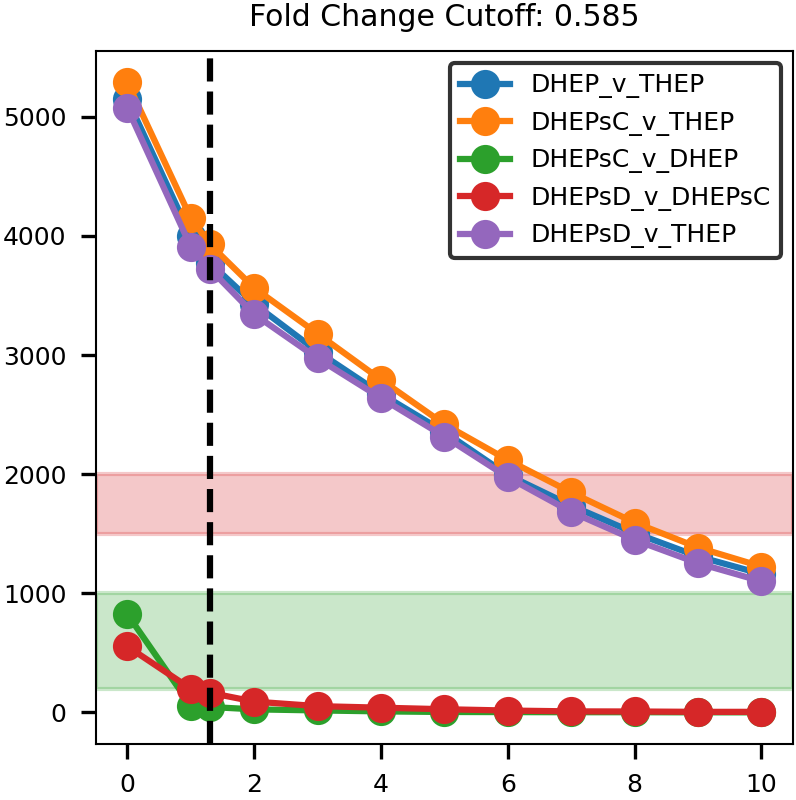

In [25]:
degnn = dorm_nets
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = dorm_conds
full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=0.585)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:red')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)
plt.title('Fold Change Cutoff: 0.585')

Text(0.5, 1.0, 'Fold Change Cutoff: 2')

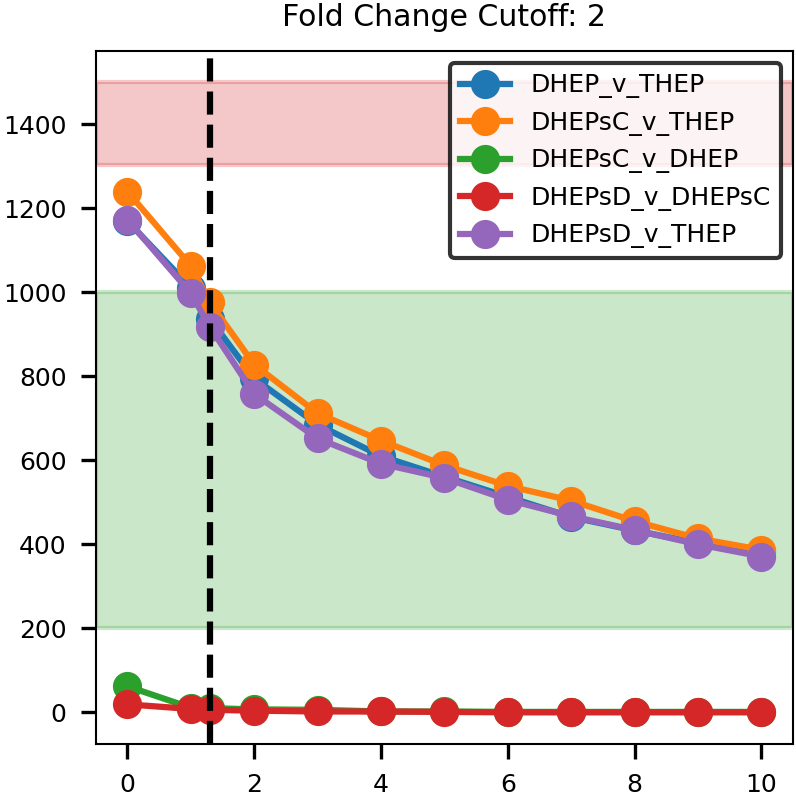

In [26]:
degnn = dorm_nets
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = dorm_conds
full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=2)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:red')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)
plt.title('Fold Change Cutoff: 2')

In [27]:
degnn = dorm_nets
for cond in ['DHEP_v_THEP', 'DHEPsC_v_THEP', 'DHEPsD_v_THEP']:
    degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05,fc_thres=2,batch_mode=True)
    degNums = len(degnn.up_DEGs + degnn.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

for cond in ['DHEPsD_v_DHEPsC','DHEPsC_v_DHEP']:
    degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05,fc_thres=0.585,batch_mode=True)
    degNums = len(degnn.up_DEGs + degnn.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

Comparison DHEP_v_THEP has 937 DEGs used for analysis.
Comparison DHEPsC_v_THEP has 976 DEGs used for analysis.
Comparison DHEPsD_v_THEP has 918 DEGs used for analysis.
Comparison DHEPsD_v_DHEPsC has 165 DEGs used for analysis.
Comparison DHEPsC_v_DHEP has 46 DEGs used for analysis.


### deDANSy Results

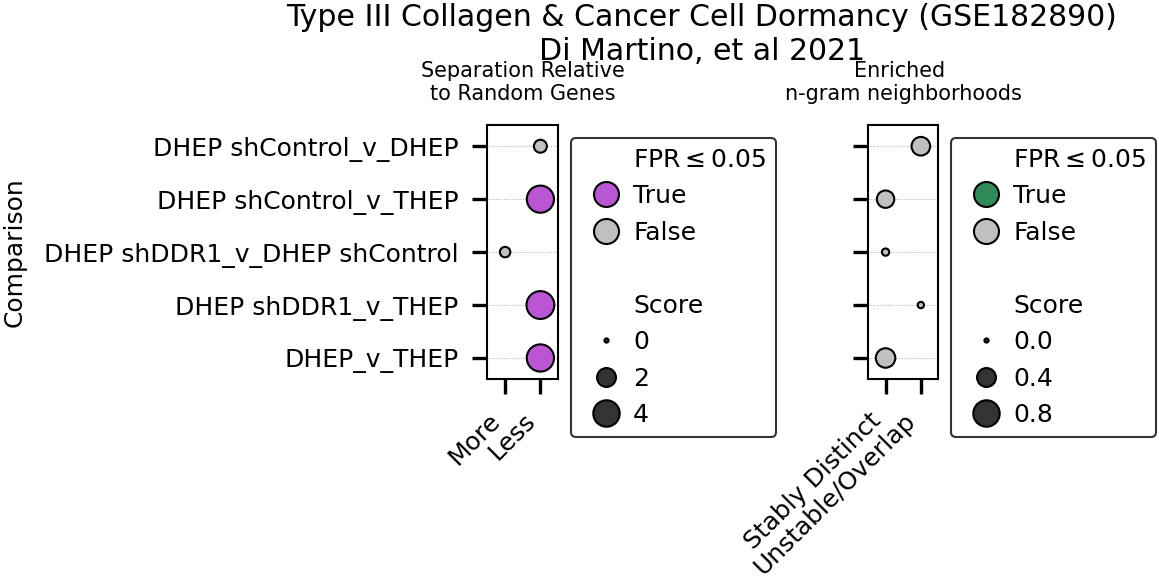

In [ ]:
# Importing the data to be plotted
files = ['dormancy_large', 'dormancy_permissive']
dataset = pd.DataFrame()
for file in files:
    filename = 'deDANSy_Results/' + file+ '_Results_Summary_Stats.csv'
    temp = pd.read_csv(filename)
    dataset = pd.concat([dataset, temp])
res = format_results(dataset)

res['Comparison']=res['Comparison'].apply(lambda x: x.replace('sC', ' shControl') if 'sC' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('sD', ' shDDR1') if 'sD' in x else x)


axs = plot_functional_scores(res, aspect=1.5)
axs[0].margins(y =0.1)
axs[1].margins(y =0.1)
plt.gcf().set_size_inches(h =1.1, w = 3)
plt.suptitle('Type III Collagen & Cancer Cell Dormancy (GSE182890)\nDi Martino, et al 2021', y = 1.25)
plt.show()
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/Dormancy_Analysis.svg')

## HAS Overexpression in breast epithelial cells

Here, we used data from this [study](https://doi.org/10.1002/adhm.202202224) (PMID: [36479976](https://pubmed.ncbi.nlm.nih.gov/36479976/)), which focused on studying how hyaluronic acid production promotes an invasive, cancer stem-like state in breast cancer cells. 

This study already defined DEGs and used the same analysis pipeline as used with the rest of the datasets. The DEG results were obtained directly from the supplementary files of the publication.

The command prompt line was as follows:

    python ngram_min_test.py DEG_data/MCF10_HAS_overexpression.csv deDANSy_Results/HASOE_50 HAS2 HAS3 -mp 8 -sN 100 -fN 50 --seed 882 -fc 1 -a 0.05  

### Defining DEGs

In [ ]:
hasOE_dataset = pd.read_csv('DEG_data/MCF10_HAS_overexpression.csv')
hasOE_deg = ngramNets.DEdansy(hasOE_dataset, gene_ID_conv, data_ids=['ensembl_gene_id','external_gene_name'], uniprot_ref=complete_ref, dbl_check=True)

The following parameters were ignored:['dbl_check']
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


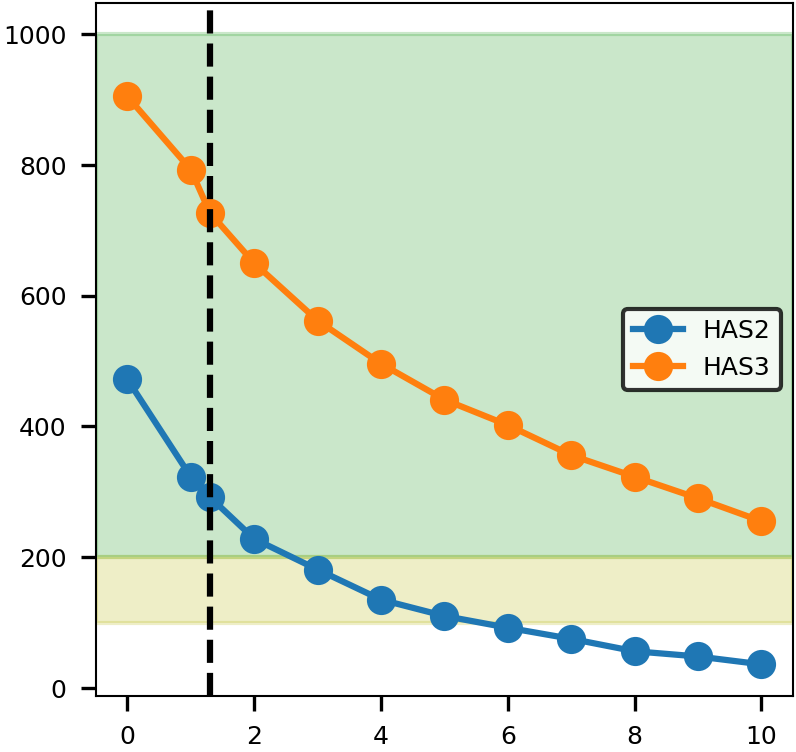

In [30]:
# Now to help with determining appropriate cutoffs for designating DEGs (Using the HAS dataset to develop and then apply on the other larger ones)
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = ['HAS2', 'HAS3']
full_degs = np.empty((2,len(p_vals)))
for j,cond in enumerate(conds):
    deg_nums = np.empty(len(p_vals))
    for i,p in enumerate(p_vals):
        hasOE_deg.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True)
        num_DEGs = len(hasOE_deg.up_DEGs + hasOE_deg.down_DEGs)
        deg_nums[i] = num_DEGs
    full_degs[j] = deg_nums

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=100, y2 = 200, alpha=0.25, color = 'tab:olive')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)


In [31]:
for cond in ['HAS2', 'HAS3']:
    hasOE_deg.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05,batch_mode=True)
    degNums = len(hasOE_deg.up_DEGs + hasOE_deg.down_DEGs)
    print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

Comparison HAS2 has 292 DEGs used for analysis.
Comparison HAS3 has 727 DEGs used for analysis.


### deDANSy Results

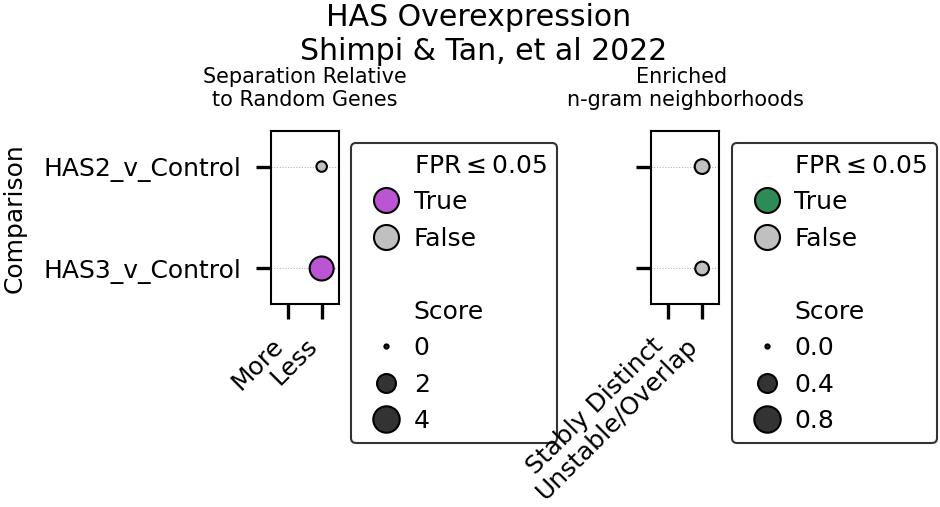

In [ ]:
# Importing the data to be plotted
files = ['HASOE_50']
dataset = pd.DataFrame()
for file in files:
    filename = 'deDANSy_Results/' + file+ '_Results_Summary_Stats.csv'
    temp = pd.read_csv(filename)
    dataset = pd.concat([dataset, temp])
res = format_results(dataset)
# Replacing some of the labels to make them more clear
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('HAS2', 'HAS2_v_Control') if 'HAS2' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('HAS3', 'HAS3_v_Control') if 'HAS3' in x else x)

axs = plot_functional_scores(res, aspect=3)
axs[0].margins(y = 0.35)
axs[1].margins(y = 0.35)

plt.gcf().set_size_inches(h =.75, w = 3)

plt.suptitle('HAS Overexpression \nShimpi & Tan, et al 2022', y = 1.45)
plt.show()
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/HAS_Example_Analysis.svg')

## Mechanical conditioning of breast cancer cells

Here, we used data from this [study](https://doi.org/10.1016/j.celrep.2021.109293), which focuses on characterizing how conditioning of cells by pre-culturing on different stiffnesses promotes phenotypic changes more conducive to metastatic dissemination.

The command line prompt is:

    python ngram_min_test.py DEG_data/Mechanical_Conditioning_DEG_Results.csv deDANSy_Results/meco soft_stiff -mp 8 -sN 100 -fN 50 --seed 882 -fc 2 -a 0.05     

In [ ]:
meco_data = pd.read_csv('DEG_data/Mechanical_Conditioning_DEG_Results.csv')
meco_nets = ngramNets.DEdansy(meco_data, gene_ID_conv,uniprot_ref=complete_ref, data_ids='ensembl_gene_id')
meco_conds = ['soft_stiff']


Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


### Defining DEGs

Will only show the fold-change cutoff of 2.

Text(0.5, 1.0, 'Fold Change Cutoff: 2')

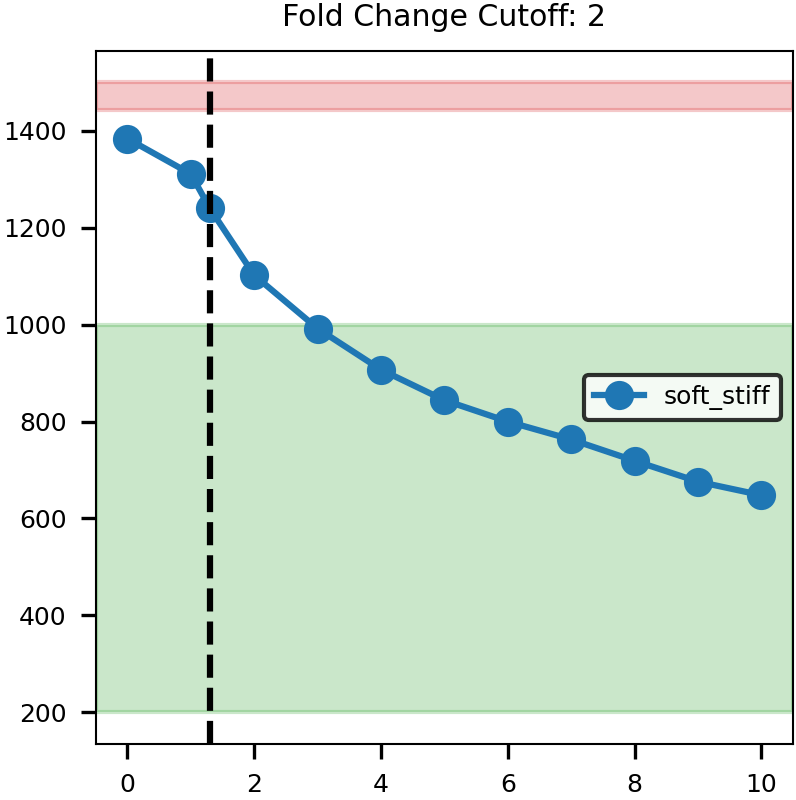

In [34]:
degnn = meco_nets
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = meco_conds
full_degs = np.zeros((len(conds),len(p_vals)))
for j,cond in enumerate(conds):
    for i,p in enumerate(p_vals):
        degnn.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True,fc_thres=2)
        num_DEGs = len(degnn.up_DEGs + degnn.down_DEGs)
        full_degs[j,i] = num_DEGs

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
ax = plt.gca()
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=1500, y2 = np.min([ax.get_ylim()[1],2000]), alpha=0.25, color = 'tab:red')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)
plt.title('Fold Change Cutoff: 2')

In [35]:
meco_nets.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.01,fc_thres=2,batch_mode=True)
degNums = len(meco_nets.up_DEGs + meco_nets.down_DEGs)
print(f'Comparison {cond} has {degNums} DEGs used for analysis.')

Comparison soft_stiff has 1102 DEGs used for analysis.


### deDANSy Results

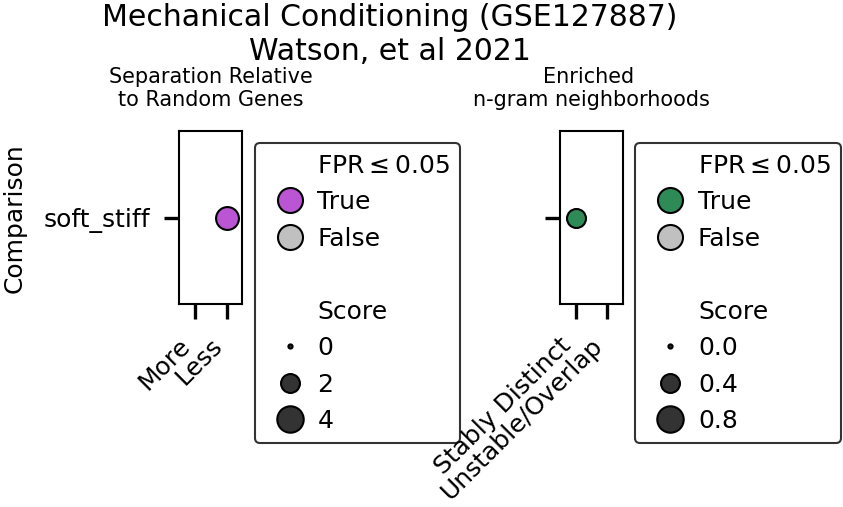

In [ ]:
# Importing the data to be plotted
files = ['meco']
dataset = pd.DataFrame()
for file in files:
    filename = 'deDANSy_Results/' + file+ '_Results_Summary_Stats.csv'
    temp = pd.read_csv(filename)
    dataset = pd.concat([dataset, temp])
res = format_results(dataset)
plot_functional_scores(res, aspect=50)
plt.gcf().set_size_inches(h =0.75, w = 3)
plt.suptitle('Mechanical Conditioning (GSE127887)\nWatson, et al 2021', y = 1.45)
plt.show()
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/Mechanical_condition_Analysis.svg')